In [395]:
import sys
sys.executable

'/Users/soul/.ssh/oiad-3-2025/.venv/bin/python3.11'

### Входные данные

In [360]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import t, norm, rankdata, fisher_exact 
import matplotlib.pyplot as plt
from math import sqrt, log, tanh, atanh

In [361]:
data_path = "../datasets/students_simple.csv"

In [362]:
dataFrame = pd.read_csv(data_path)
print(dataFrame.head())

   height  mass  income   iq  pages  age    bmi  work_exp  friends  test_time
0     159    45     430   95     24   20  3.533        26        5        8.5
1     160    61     640  115     32   25  2.623        63        7        6.2
2     161    56     610  111     24   28  2.875        94       10        6.8
3     162    48     330   97     24   19  3.375        16        4       12.0
4     162    54     420  105     60   23  3.000        49        2        7.5


In [363]:
N = 29
N1 = N % 5
N2 = (N ** 2) % 5 + 5
N1, N2

(4, 6)

In [364]:
x = dataFrame.iloc[:, N1]
x

0     24
1     32
2     24
3     24
4     60
5     16
6     90
7     24
8     48
9     24
10    16
11    48
12    32
13    48
14    64
15    48
16    90
17    48
18    32
19    60
Name: pages, dtype: int64

In [365]:
y = dataFrame.iloc[:, N2]
y

0     3.533
1     2.623
2     2.875
3     3.375
4     3.000
5     2.828
6     3.255
7     2.726
8     2.429
9     2.361
10    2.342
11    2.672
12    2.356
13    2.559
14    2.173
15    2.095
16    2.342
17    2.011
18    2.691
19    2.021
Name: bmi, dtype: float64

In [366]:
x.count()

np.int64(20)

In [367]:
n = 20

### 1. Расчет корреляций

In [368]:
x_mean = np.mean(x)
y_mean = np.mean(y)

**1. Фехнера**

$$ K = \frac{ \sum_{i=1}^{n} [sign(x_i - \overline{x}) = sign(y_i - \overline{y})] - [sign(x_i - \overline{x}) \ne sign(y_i - \overline{y})] }{n} $$

In [369]:
x_sign = np.sign(x - x_mean)
y_sign = np.sign(y - y_mean)

In [370]:
same = np.sum(x_sign == y_sign)
diff = np.sum(x_sign != y_sign) 

In [371]:
K_fechner = (same - diff) / n
K_fechner

np.float64(-0.4)

**2. Пирсона + доверительный интервал**

$$ \text{cov}(x, y) = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{n-1} $$

$$ K = \frac{\text{cov}(x, y)}{S_x S_y} $$

$$ S_x^2 = \frac{\sum_{i=1}^n (x_i - \overline{x})^2}{n-1}, \quad S_y^2 = \frac{\sum_{i=1}^n (y_i - \overline{y})^2}{n-1} $$

$$ T = \frac{K \sqrt{n-2}}{\sqrt{1 - K^2}} $$

In [372]:
cov = np.sum((x - x_mean)*(y - y_mean)) / (n - 1)
Sx = np.sqrt(np.sum((x - x_mean)**2) / (n - 1))
Sy = np.sqrt(np.sum((y - y_mean)**2) / (n - 1))

In [373]:
K_pearson = cov / (Sx * Sy)
K_pearson

np.float64(-0.1794973280072121)

In [374]:
T = K_pearson * np.sqrt(n - 2) / np.sqrt(1 - K_pearson**2)
T

np.float64(-0.7741154941595184)

In [394]:
alpha = 0.05

# Fisher z-преобразование
z = 0.5 * np.log((1 + K_pearson) / (1 - K_pearson))
se = 1 / np.sqrt(n - 3)

z_crit = stats.norm.ppf(1 - alpha/2)  

z_lower = z - z_crit * se
z_upper = z + z_crit * se

r_lower = (np.exp(2*z_lower) - 1) / (np.exp(2*z_lower) + 1)
r_upper = (np.exp(2*z_upper) - 1) / (np.exp(2*z_upper) + 1)

print(r_lower, r_upper)

-0.5762461319405012 0.285718440751068


**3. Спирмена**

In [376]:
Rx = rankdata(x)
Ry = rankdata(y)

In [377]:
Rx_mean = np.mean(Rx)
Ry_mean = np.mean(Ry)

In [378]:
numerator = np.sum((Rx - Rx_mean) * (Ry - Ry_mean))
denominator = np.sqrt(np.sum((Rx - Rx_mean)**2) * np.sum((Ry - Ry_mean)**2))

In [379]:
K_spearman = numerator / denominator
K_spearman

np.float64(-0.3239399782654808)

**4. Кенделла**

$$ K = 1 - \frac{4}{n (n - 1)} 
\sum_{i=1}^{n-1} 
\sum_{j=i+1}^{n} 
\big[ [x_i < x_j] \ne [y_i < y_j] \big] $$

In [380]:
diff_count = 0
for i in range(n - 1):
    for j in range(i + 1, n):
        x_comp = x[i] < x[j]
        y_comp = y[i] < y[j]
        if x_comp != y_comp:
            diff_count += 1

In [381]:
K_kendall = 1 - (4 * diff_count) / (n * (n - 1))
K_kendall

-0.1473684210526316

In [382]:
diff_count = 0
for i in range(n - 1):
    for j in range(i + 1, n):
        x_comp = Rx[i] < Rx[j]
        y_comp = Ry[i] < Ry[j]
        if x_comp != y_comp:
            diff_count += 1

In [383]:
K_kendall2 = 1 - (4 * diff_count) / (n * (n - 1))
K_kendall2

-0.1473684210526316

### 2. Визуализация 

**1. Гистограммы**


In [384]:
k = 1 + int(np.log2(y.count())) # правило Стюрджеса
print(k)

5


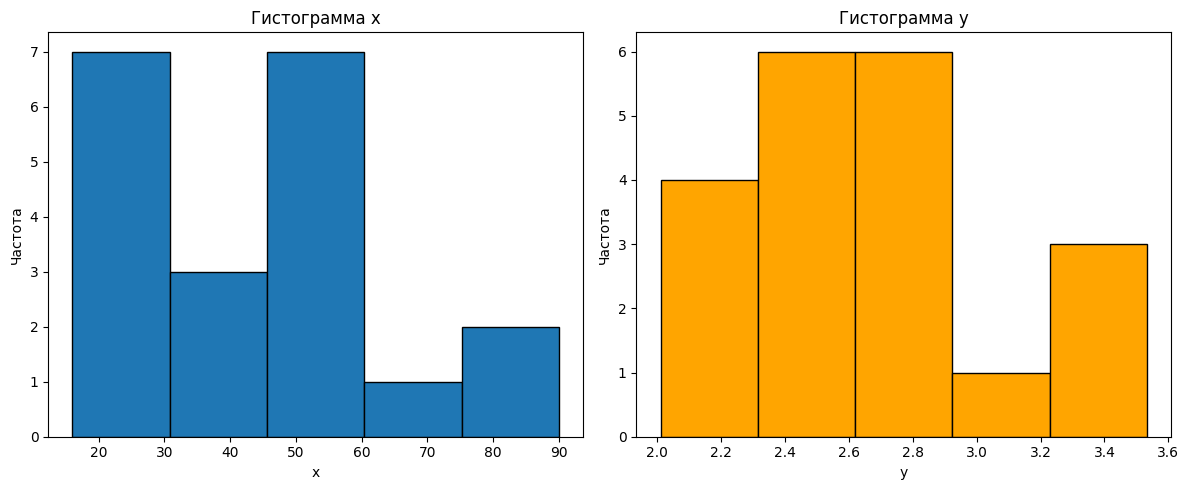

In [385]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(x, bins=k, edgecolor='black')
plt.title('Гистограмма x')
plt.xlabel('x')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(y, bins=k, color='orange', edgecolor='black')
plt.title('Гистограмма y')
plt.xlabel('y')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

**2. График рассеяния (scatter plot)**

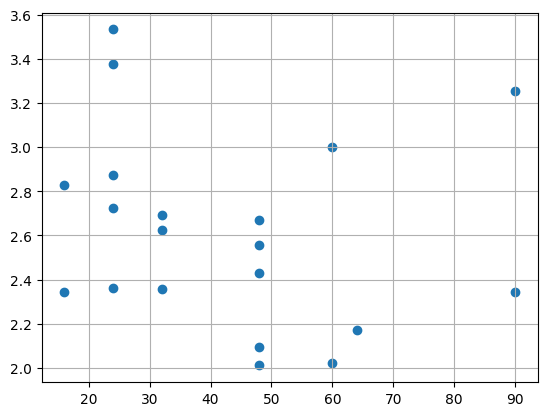

In [386]:
plt.scatter(x, y)
plt.grid(True)

### 3. Уравнение регрессии 

1. линейная, $$ y = w_1x + w_0 $$

$$ w^* = (X^T X)^{-1} X^T y $$

In [387]:
X = np.c_[x, np.ones(len(x))]
w = np.linalg.inv(X.T @ X) @ X.T @ y

w1, w0 = w
w1, w0

(np.float64(-0.0035606872223673883), np.float64(2.76503527567285))

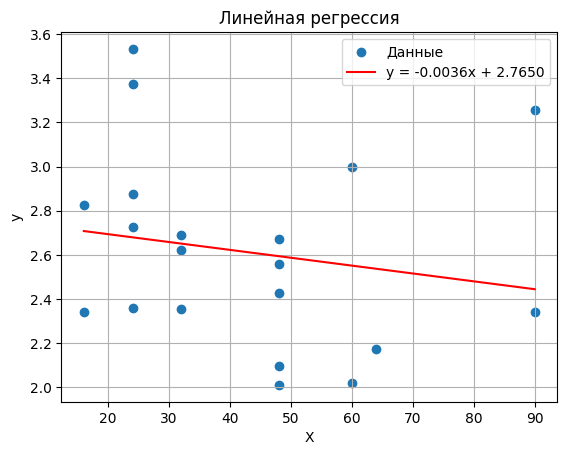

In [388]:
x_line = np.linspace(min(x), max(x), 100)
y_line = w1 * x_line + w0

plt.scatter(x, y, label='Данные')
plt.plot(x_line, y_line, color='red', label=f'y = {w1:.4f}x + {w0:.4f}')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Линейная регрессия')
plt.legend()
plt.grid(True)
plt.show()

2. квадратичная, $$ y = w_2x^2 + w_1x + w_0 $$

In [390]:
X = np.vstack([x**2, x, np.ones(len(x))]).T
w = np.linalg.inv(X.T @ X) @ X.T @ y
w2, w1, w0 = w
w2, w1, w0

(np.float64(0.0003268599957357481),
 np.float64(-0.037128961098515656),
 np.float64(3.4517641124936764))

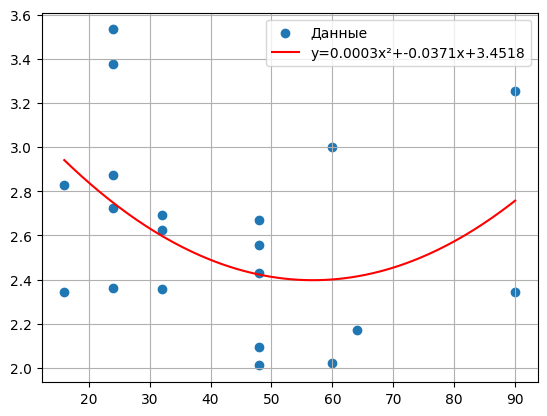

In [391]:
x_line = np.linspace(min(x), max(x), 200)
y_line = w2*x_line**2 + w1*x_line + w0

plt.scatter(x, y, label='Данные')
plt.plot(x_line, y_line, color='red', label=f'y={w2:.4f}x²+{w1:.4f}x+{w0:.4f}')
plt.legend()
plt.grid(True)
plt.show()

In [392]:
fisher_exact([w2*x**2 + w1*x + w0, y])

SignificanceResult(statistic=np.float64(1.846207238682934e-08), pvalue=np.float64(1.0))

3. гиперболическая, $$ y = \frac{w_1}{x} + w_0 $$
$$ y = w_1 * \frac{1}{x} + w_0 $$

In [393]:
X = np.vstack([1/x, np.ones(len(x))]).T
w = np.linalg.inv(X.T @ X) @ X.T @ y
w1, w0 = w
w1, w0

(np.float64(7.3406685046182805), np.float64(2.392237849730681))

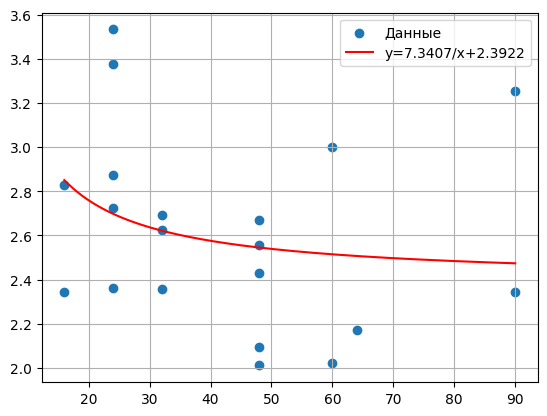

In [354]:
x_line = np.linspace(min(x), max(x), 200)
y_line = w1/x_line + w0

plt.scatter(x, y, label='Данные')
plt.plot(x_line, y_line, color='red', label=f'y={w1:.4f}/x+{w0:.4f}')
plt.legend()
plt.grid(True)
plt.show()

4. показательная, $$ y = w_1^x * w_0 $$
$$ \ln y = \ln w_1 * x + \ln w_0 $$
$$ y' = B_1 x + B_0 $$

In [356]:
y_l = np.log(y)
X_l = np.vstack([x, np.ones(len(x))]).T

B = np.linalg.inv(X_l.T @ X_l) @ X_l.T @ y_l
B1, B0 = B

w1 = np.exp(B1)
w0 = np.exp(B0)
w1, w0

(np.float64(0.9985554453979646), np.float64(2.743893539977674))

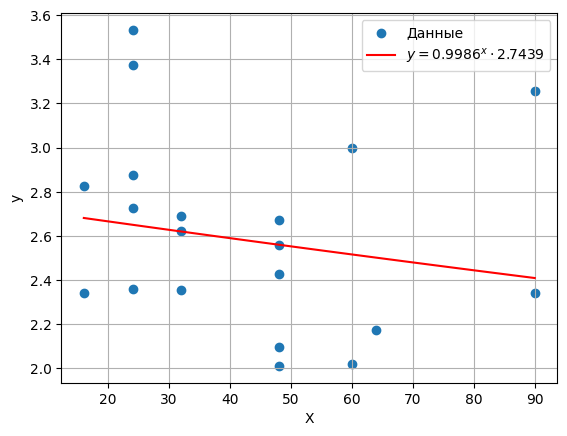

In [357]:
x_line = np.linspace(min(x), max(x), 100)
y_line = (w1**x_line) * w0

plt.scatter(x, y, label='Данные')
plt.plot(x_line, y_line, color='red', label=f'$y = {w1:.4f}^x \cdot {w0:.4f}$')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [358]:
fisher_exact([(w1**x) * w0, y])

SignificanceResult(statistic=np.float64(1.846207238682934e-08), pvalue=np.float64(1.0))